# Compare the single-nucleon and pair $\delta U \delta U^\dagger$ terms

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ September 11, 2023

Check if the slope is about the same in the $\delta U \delta U^\dagger$ terms (taking $S$-wave channels only) using `vegas` integration

_Last update:_ September 11, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from numpy.linalg import norm
from scipy.interpolate import RectBivariateSpline
import time
import vegas

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters
from scripts.integration import (gaussian_quadrature_mesh, momentum_mesh,
                                 unattach_weights_from_matrix)
from scripts.potentials import Potential
from scripts.srg import load_srg_transformation

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
@njit
def build_vector(k, theta, phi):
    """
    Build a vector from input spherical coordinates.

    Parameters
    ----------
    k : float
        Magnitude of the vector.
    theta : float
        Polar angle of the vector in the range [0, \pi].
    phi : float
        Azimuthal angle of the vector in the range [0, 2\pi].

    Returns
    -------
    k_vector : 1-D ndarray
        Output vector with shape (3,1).

    """

    k_vector = np.array([k * np.sin(theta) * np.cos(phi),
                         k * np.sin(theta) * np.sin(phi),
                         k * np.cos(theta)])

    return k_vector

In [5]:
@njit
def get_vector_components(k_vector):
    """
    Get the spherical coordinates from an input vector.

    Parameters
    ----------
    k_vector : 1-D ndarray
        Input vector with shape (3,1).

    Returns
    -------
    k : float
        Magnitude of the vector.
    theta : float
        Polar angle of the vector in the range [0, \pi].
    phi : float
        Azimuthal angle of the vector in the range [0, 2\pi].

    """

    k = norm(k_vector)
    theta = np.arccos(k_vector[2]/k)
    phi = np.arctan2(k_vector[1], k_vector[0])

    return k, theta, phi

In [6]:
class DeltaUMatrixElement:
    """DOCSTRING"""
    
    def __init__(self, kvnn, kmax, kmid, ntot, generator, lamb):

        # Set \delta U and \delta U^\dagger functions
        self.get_delta_U_functions(kvnn, kmax, kmid, ntot, generator, lamb)
    
    
    def __call__(self, k, theta_k, phi_k, kp, theta_kp, phi_kp, hc=False):
        """Sum over partial waves to evaluate \delta U matrix element in
        plane-wave basis.
        """
        
        matrix_element = 0
        for channel in ['1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1']:
            
            # \delta U^\dagger in partial-wave basis
            if hc:
                delta_U_partial_wave = self.delUdag_functions[channel].ev(k, kp)
            # \delta U in partial-wave basis
            else:
                delta_U_partial_wave = self.delU_functions[channel].ev(k, kp)
            
            matrix_element += delta_U_partial_wave
    
        return matrix_element
    
    
    def interpolate_delta_U(self, channel, potential, generator, lamb,
                            hc=False):
        """Interpolate \delta U(k, k') for the given channel."""

        # Get momentum mesh
        kmax, kmid, ntot = potential.kmax, potential.kmid, potential.ntot
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get SRG transformation with integration weights [unitless]
        U_matrix_weights = load_srg_transformation(potential, generator, lamb)

        # Calculate \delta U = U - I
        I_matrix_weights = np.eye(len(U_matrix_weights))
        if hc:  # Hermitian conjugate
            delU_matrix_weights = (U_matrix_weights - I_matrix_weights).T
        else:
            delU_matrix_weights = U_matrix_weights - I_matrix_weights

        # Get specific sub-block if coupled-channel and unattach weights
        if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            delU_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delU_matrix_weights[:ntot,ntot:]
            )
        elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            delU_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delU_matrix_weights[ntot:,:ntot]
            )
        elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            delU_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delU_matrix_weights[ntot:,ntot:]
            )
        else:
            delU_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delU_matrix_weights[:ntot,:ntot]
            )
        
        # Interpolate \delta U(k, k')
        delU_func = RectBivariateSpline(k_array, k_array, delU_matrix)

        return delU_func
        
    
    def get_delta_U_functions(self, kvnn, kmax, kmid, ntot, generator, lamb):
        """Get \delta U and \delta U^\dagger functions."""
        
        self.delU_functions = {}
        self.delUdag_functions = {}
        
        for channel in ['1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1']:
            
            if channel[:3] == '1S0':
                channel_arg = channel
            else:
                channel_arg = '3S1'
                
            # Potential in 1S0 partial wave channel
            potential = Potential(kvnn, channel_arg, kmax, kmid, ntot)

            # Set \delta U and \delta U^\dagger functions
            self.delU_functions[channel] = self.interpolate_delta_U(
                channel, potential, generator, lamb)
            self.delUdag_functions[channel] = self.interpolate_delta_U(
                channel, potential, generator, lamb, hc=True)

In [7]:
class SingleNucleonIntegrand:
    """Evaluates the integrand of the single-nucleon distribution."""
    
    
    def __init__(self, q, delta_U_matrix_element):
        
        # Set instance attributes
        self.q = q
        self.delta_U_matrix_element = delta_U_matrix_element

        
    def __call__(self, x_array):
        
        # Choose z-axis to be along q_vector
        q_vector = np.array([0, 0, self.q])
        
        # Relative momenta k
        k, theta_k, phi_k = x_array[0:3]
        
        # Relative momenta k'
        kp, theta_kp, phi_kp = x_array[3:6]
        
        # C.o.M. momenta K
        K, theta_K, phi_K = x_array[6:9]
        K_vector = build_vector(K, theta_K, phi_K)

        # Calculate vector q - K/2
        qK_vector = q_vector - K_vector/2
        qK, theta_qK, phi_qK = get_vector_components(qK_vector)

        # Calculate the Jacobian determinant
        jacobian = (k ** 2 * np.sin(theta_k) * kp ** 2 * np.sin(theta_kp)
                    * K ** 2 * np.sin(theta_K))
        
        # Matrix elements of \delta U and \delta U^\dagger
        delta_U = self.delta_U_matrix_element(k, theta_k, phi_k, qK, theta_qK,
                                              phi_qK, hc=False)
        delta_U_dag = self.delta_U_matrix_element(qK, theta_qK, phi_qK, kp,
                                                  theta_kp, phi_kp, hc=True)
        
        return jacobian * delta_U * delta_U_dag

In [8]:
class PairIntegrand:
    """Evaluates the integrand of the pair distribution."""
    
    
    def __init__(self, q, delta_U_matrix_element):
        
        # Set instance attributes
        self.q = q
        self.delta_U_matrix_element = delta_U_matrix_element

        
    def __call__(self, x_array):
        
        # Choose z-axis to be along q_vector
        q_vector = np.array([0, 0, self.q])
        
        # Relative momenta k
        k, theta_k, phi_k = x_array[0:3]
        
        # Relative momenta k'
        kp, theta_kp, phi_kp = x_array[3:6]

        # Calculate the Jacobian determinant
        jacobian = k ** 2 * np.sin(theta_k) * kp ** 2 * np.sin(theta_kp)
        
        # Matrix elements of \delta U and \delta U^\dagger
        delta_U = self.delta_U_matrix_element(k, theta_k, phi_k, self.q, 0, 0,
                                              hc=False)
        delta_U_dag = self.delta_U_matrix_element(self.q, 0, 0, kp, theta_kp,
                                                  phi_kp, hc=True)
        
        return jacobian * delta_U * delta_U_dag

In [9]:
def compute_single_nucleon(q_array, delta_U_matrix_element, neval):
    """Compute the single-nucleon."""

    # Relative momenta from 0 to 10 fm^-1
    # k_limits = [0, 10]
    k_limits = [0, 1.5]
    # C.o.M. momenta up to 3 fm^-1
    K_limits = [0, 3]
    # Polar angle from 0 to \pi
    theta_limits = [0, np.pi]
    # Azimuthal angle from 0 to 2\pi
    phi_limits = [0, 2*np.pi]

    # Set-up integrator with multiple processors
    integ = vegas.Integrator([
        k_limits, theta_limits, phi_limits,
        k_limits, theta_limits, phi_limits,
        K_limits, theta_limits, phi_limits,
    ], nproc=1)

    # Evaluate the \delta U + \delta U^\dagger term for each q
    delta_U2_array = np.zeros_like(q_array)
    delta_U2_errors = np.zeros_like(q_array)
    for i, q in enumerate(q_array):

        integrand = SingleNucleonIntegrand(q, delta_U_matrix_element)
        
        # Train the integrator
        integ(integrand, nitn=5, neval=neval)
    
        # Final result
        result = integ(integrand, nitn=10, neval=neval)
        
        delta_U2_array[i] = result.mean
        delta_U2_errors[i] = result.sdev

    return delta_U2_array, delta_U2_errors

In [10]:
def compute_pair(q_array, delta_U_matrix_element, neval):
    """Compute the single-nucleon."""

    # Relative momenta from 0 to 10 fm^-1
    # k_limits = [0, 10]
    k_limits = [0, 1.5]
    # Polar angle from 0 to \pi
    theta_limits = [0, np.pi]
    # Azimuthal angle from 0 to 2\pi
    phi_limits = [0, 2*np.pi]

    # Set-up integrator with multiple processors
    # IN A JUPYTER NOTEBOOK YOU HAVE TO USE nproc=1!
    integ = vegas.Integrator([
        k_limits, theta_limits, phi_limits,
        k_limits, theta_limits, phi_limits,
    ], nproc=1)

    # Evaluate the \delta U + \delta U^\dagger term for each q
    delta_U2_array = np.zeros_like(q_array)
    delta_U2_errors = np.zeros_like(q_array)
    for i, q in enumerate(q_array):

        integrand = PairIntegrand(q, delta_U_matrix_element)
        
        # Train the integrator
        integ(integrand, nitn=5, neval=neval)
    
        # Final result
        result = integ(integrand, nitn=10, neval=neval)
        
        delta_U2_array[i] = result.mean
        delta_U2_errors[i] = result.sdev

    return delta_U2_array, delta_U2_errors

In [11]:
def main(kvnn, q_array, kmax=15.0, kmid=3.0, ntot=120, generator='Wegner',
         lamb=1.5, neval=1e3):
    """Compare the single-nucleon and pair distributions."""
    
    # Initialize \delta U matrix element class
    delta_U_matrix_element = DeltaUMatrixElement(kvnn, kmax, kmid, ntot,
                                                 generator, lamb)
    
    # Compute single-nucleon
    t0 = time.time()
    snmd_delU2_array, snmd_delU2_errors = compute_single_nucleon(
        q_array, delta_U_matrix_element, neval) 
    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done with single-nucleon after {mins:.5f} minutes.")
    
    # Compute pair
    t0 = time.time()
    pmd_delU2_array, pmd_delU2_errors = compute_pair(
        q_array, delta_U_matrix_element, neval)
    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done with pair after {mins:.5f} minutes.")
    
    # Multiply pair by integration volume of Q_vector
    Q_array, Q_weights = gaussian_quadrature_mesh(3.0, 50)
    factor = 4*np.pi * np.sum(Q_array ** 2 * Q_weights)
    pmd_delU2_array *= factor
    pmd_delU2_errors *= factor
    
    return (snmd_delU2_array, snmd_delU2_errors, pmd_delU2_array,
            pmd_delU2_errors)

In [12]:
kvnn = 6
# Set points in q
qmax, qmid, ntot_q, nmod_q = 10.0, 2.0, 80, 40
q_array, _ = momentum_mesh(qmax, qmid, ntot_q, nmod=nmod_q)

snmd_delU2_array, snmd_delU2_errors, pmd_delU2_array, pmd_delU2_errors = main(
    kvnn, q_array)

Done with single-nucleon after 0.40203 minutes.
Done with pair after 0.32777 minutes.


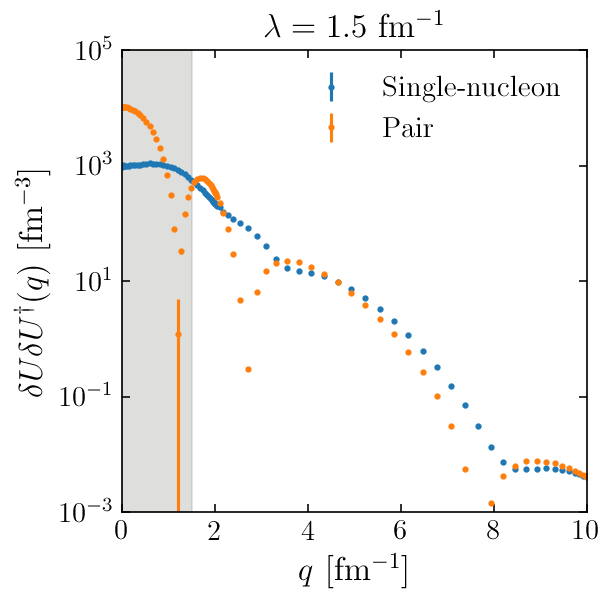

In [25]:
# Plot
x_limits = (0, 10)
y_limits = (1e-3, 1e5)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.errorbar(q_array, snmd_delU2_array, yerr=snmd_delU2_errors,
            label='Single-nucleon', linestyle='', marker='o', markersize=2.0)
ax.errorbar(q_array, pmd_delU2_array, yerr=pmd_delU2_errors, label='Pair',
            linestyle='', marker='o', markersize=2.0)
ax.fill_betweenx(y_limits, 0.0, 1.5, alpha=0.3, edgecolor='xkcd:grey',
                 facecolor='xkcd:grey')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$\delta U \delta U^\dagger(q)$ [fm" + r'$^{-3}$' + ']',
              fontsize=16)
ax.legend(loc='upper right', fontsize=14, frameon=False)
ax.set_title(r'$\lambda = 1.5$ fm' + r'$^{-1}$', fontsize=16)
plt.show()

$$
n^{\tau}(\mathbf{q}) \sim \int^{2\lambda}_0 d\mathbf{K} \int^{\lambda}_0 d\mathbf{k} \int^{\lambda}_0 d\mathbf{k'}
    \delta U(k,\lvert \mathbf{q}-\mathbf{K}/2 \rvert) \delta U^\dagger(\lvert \mathbf{q}-\mathbf{K}/2 \rvert, k')
$$

$$
n^{\tau \tau'}(\mathbf{q}) \sim \int^{2\lambda}_0 d\mathbf{Q} \int^{\lambda}_0 d\mathbf{k} \int^{\lambda}_0 d\mathbf{k'} \delta U(k,q) \delta U^\dagger(q, k')
$$